In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.append("../../")
from mat_interp.model.viz_model import plot_entropy_curve
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualization of raw experimental data and property calculation without interpolation

## **The problem**: Entropy calculation
To calculate the desired target quantity, a series of mathetical operations are required.
For example, here we are interested in the magnetic entropy change ($\Delta$S$_{M}$), given by:

$$
\begin{equation}
\Delta S_{M} (T, \mu_{0}\Delta H = H_{f} - H_{i}) = \mu_{0}\int_{H_{i}}^{H_{f}} \left(\frac{\partial M}{\partial T}\right)_{H} dH
\end{equation}
$$
Below, we show that using the raw experimental data measured leads to an 'spiky' oscilating behavior due to the lack of measurement in a more fine field step.


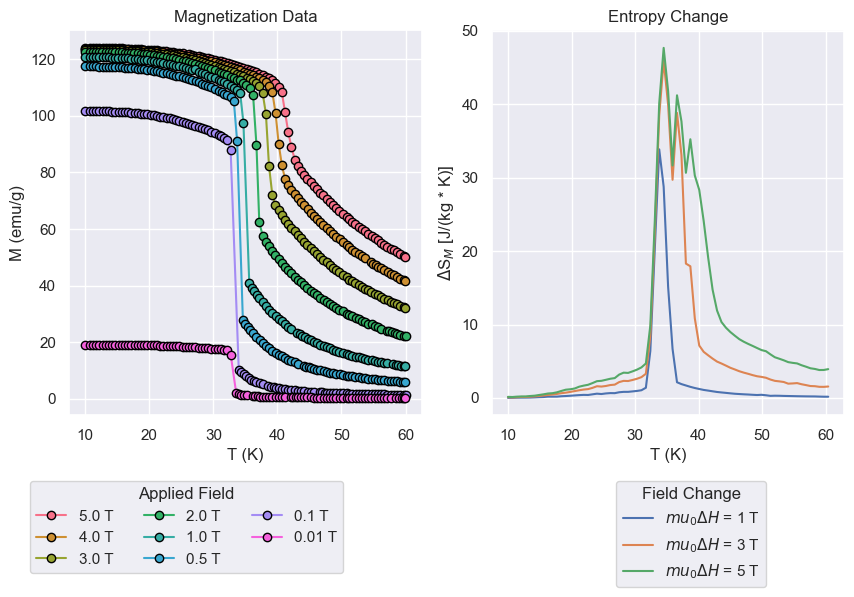

In [103]:
EXP_DATA = "../example_data/traindata_Section3_1.csv"
exp_df = pd.read_csv(EXP_DATA)

entropy_exp = plot_entropy_curve(data = exp_df, 
                                 temperature_column = "X1_demo1", 
                                 field_column="X2_demo1", 
                                 magnetization_column = "Y_demo1",
                                 return_entropy = True)

It is clear that with only those few fields measured (that is the often the common fields measured to calculate the entropy change assuming a material is of second-order), that those spiky values does not represent the true value. Specially, in the case of magnetocaloric materials, where the peak value of the entropy curve is used as base for comparison and calculation of different figure of merits (FOMs), this behavior can lead to a great overestimation of it.

Now here, we show that, by only using these few measured fields, it is possible to simulate at what step is necessary for us do redo our measurement in order to have a better accurate estimation of the entropy curve shape and values. Lets first, start by using a pre-trained model discussed in the paper, and later on lets move how to train and field the neural net that can do this.

# Simulating the data using the pre-trained model

Here we will show the simulation using two different models. For comparison with training data we show only the model discussed in the paper using the Streamlit interface. For comparison, we also show the model found by using the later section of this notebook (using jupyter interface).

In [146]:
SAVED_WEIGHTS = "weights"
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow_addons.metrics import RSquare
model = tf.keras.models.load_model(SAVED_WEIGHTS)

## Generating the same data as training data

In [83]:
# Get the features from the training experimental dataset and simulate magnetization
exp_df = pd.read_csv(EXP_DATA) # R
mean = exp_df['Y_demo1'].mean()
std = exp_df['Y_demo1'].std()
train_features = exp_df.loc[:, ['X1_demo1', 'X2_demo1']].to_numpy()
simulated_magnetization = model.predict(train_features)
simulated_df = pd.DataFrame(data = train_features, columns=['t', 'h'])
simulated_df['m_sim'] = simulated_magnetization
simulated_df['m_sim'] = (simulated_df['m_sim']) * std + mean # Unscale target

Text(0, 0.5, 'M (emu/g)')

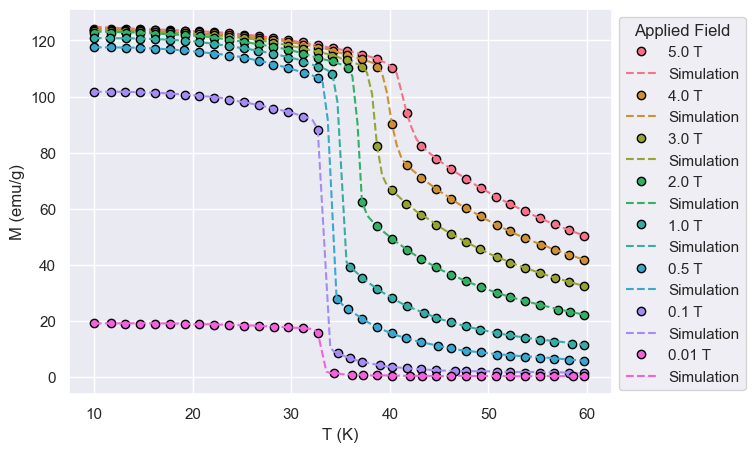

In [84]:
# Lets see the new data
WEIGHT = 0.61 * 1e-3
fig, ax = plt.subplots(figsize=(7,5))
colors = sns.color_palette(palette="husl", n_colors=len(measured_fields))
for field, clr in zip(measured_fields, colors):
    df_plot = exp_df.query('X2_demo1 == @field')
    df_plot_sim = simulated_df.query('h == @field')
    plt.plot(df_plot['X1_demo1'], df_plot['Y_demo1'] / WEIGHT, 'o',label=f"{field / 1e4} T", color=clr, mec='black', markevery=3)
    plt.plot(df_plot_sim.t, df_plot_sim['m_sim'] / WEIGHT, '--',color=clr, label="Simulation", lw=1.5)
    
plt.legend(bbox_to_anchor=(1,1), title="Applied Field")
plt.xlabel("T (K)")
plt.ylabel("M (emu/g)")


## Generating data for new field steps

Ok now lets generate new field steps and see if we can get rid of the spikes. This will use the model mentioned in the paper

In [85]:
from mat_interp.model.viz_model import generate_data_mce

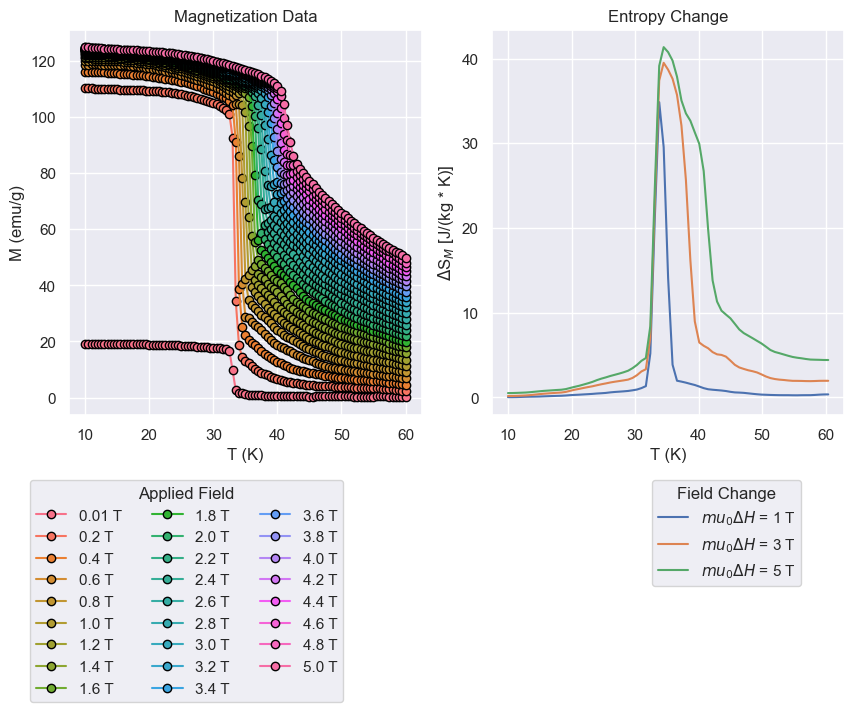

In [147]:
sim_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
sim_entropy = plot_entropy_curve(data=sim_data, 
                                 temperature_column="t", 
                                 field_column="h", 
                                 magnetization_column="m", 
                                 unstandarize=True,  
                                 bbox_mag = (0.8, -0.15), 
                                 n_cols=3, 
                                 bbox_ds = (0.9, -0.15),
                                 return_entropy = True)

Now lets use a model traiend using jupyter

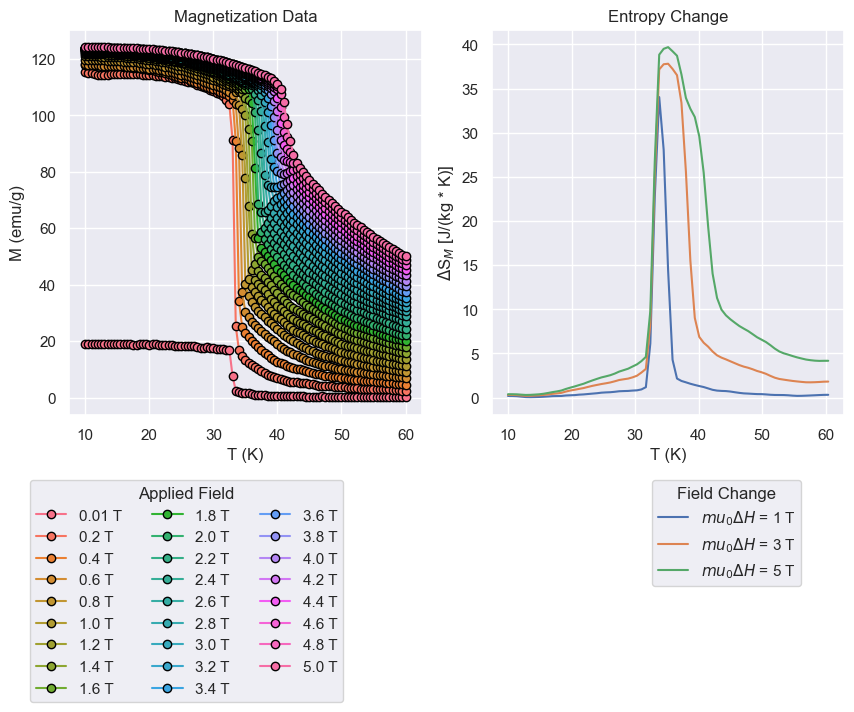

In [145]:
SAVED_WEIGHTS = "weights_jupyter"
model = tf.keras.models.load_model(SAVED_WEIGHTS)
sim_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
jupyter_sim = plot_entropy_curve(data=sim_data, temperature_column="t", field_column="h", magnetization_column="m", unstandarize=True,  bbox_mag = (0.8, -0.15), n_cols=3, bbox_ds = (0.9, -0.15), return_entropy = True)

## Finally lets visualize them together for 5 T

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

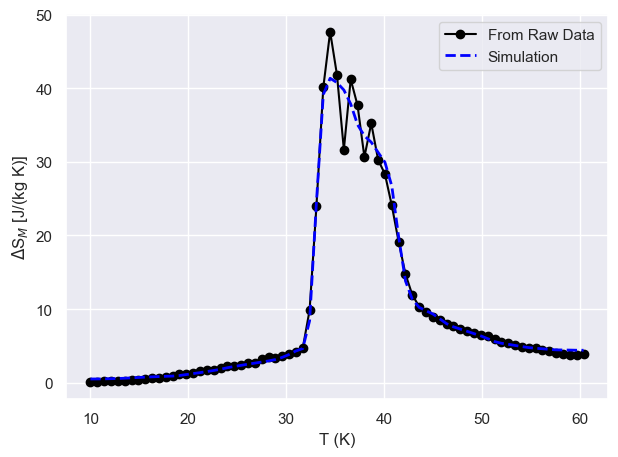

In [87]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'o-', mec='black', label = "From Raw Data", color='black')
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation", color='blue', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Checking up with the real (measured) data
We have just shown that if we simulate the data into 0.25 T steps, it would be enough to obtain a smooth non-spiky curve that does not overshoots the real value of the maxiumum entropy change. Lets compare, if we measured in this setup, how it would be in reality.

In [148]:
exp_data_fine = pd.read_csv("../example_data/experimental/fine_step.csv")

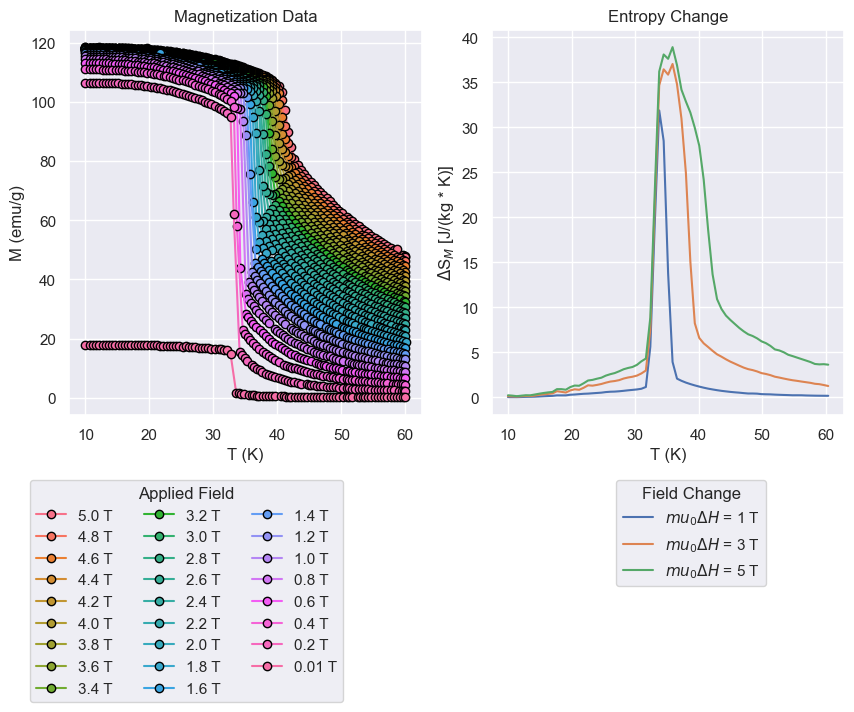

In [149]:
entropy_fine = plot_entropy_curve(exp_data_fine, temperature_column="t", magnetization_column="m", field_column="h", return_entropy=True)

## Lets compare now with the previously simulated data

> Note: The fine step data was taken from the same sample as the coarse one after a period of time has passed. The lower net magnetization observed is due to the the degradation of the sample with time (this experiments was done in a large time period over many months)

## Calculating the simulated entropy

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

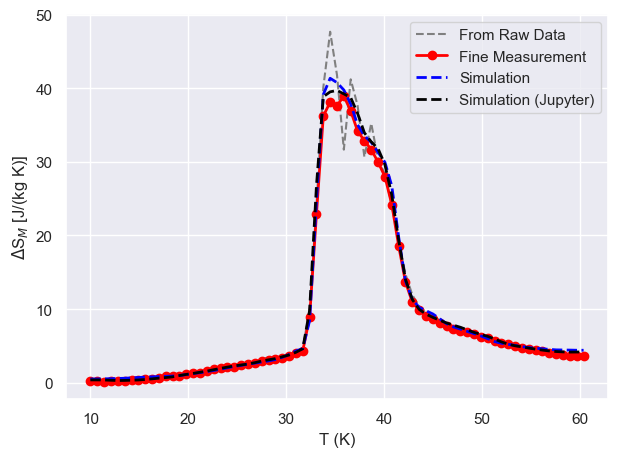

In [150]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    df_plot_3 = entropy_fine.query("dh == @field")
    df_plot_4 = jupyter_sim.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'--', mec='black', label = "From Raw Data", color='grey')
    plt.plot(df_plot_3.t, df_plot_3.ds,'o-', label = "Fine Measurement", color='red', lw=2)
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation", color='blue', lw=2)
    plt.plot(df_plot_4.t, df_plot_4.ds,'--', label = "Simulation (Jupyter)", color='black', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Finding a new model

In [117]:
from mat_interp.model.train_model import load_train_data, optimize_neural_net

# Setup the data (same as before) and the target columsn
EXP_DATA = "../example_data/traindata_Section3_1.csv"
feature_columns = ['X1_demo1', 'X2_demo1']
target_column = ['Y_demo1']
X_train, y_train = load_train_data(EXP_DATA, feature_columns, target_column)

In [ ]:
# Search settings
nn_settings = {
    "epochs": 500,
    "solver": "Adam",
    "X_train": X_train,
    "y_train": y_train,
    "num_trials": 70,
    "working_dir": "optest"
}

# Run search
optimize_neural_net(nn_settings)

[I 2022-12-16 15:54:25,043] A new study created in memory with name: optuna_NNtemp
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


Starting optimization process...


[I 2022-12-16 15:57:27,996] Trial 4 pruned. Trial was pruned at epoch 50.
[I 2022-12-16 15:57:28,014] Trial 9 pruned. Trial was pruned at epoch 50.
[I 2022-12-16 15:57:33,275] Trial 2 pruned. Trial was pruned at epoch 50.
[I 2022-12-16 15:57:40,028] Trial 5 pruned. Trial was pruned at epoch 50.
[I 2022-12-16 15:57:44,713] Trial 11 pruned. Trial was pruned at epoch 50.
[I 2022-12-16 15:57:51,736] Trial 13 pruned. Trial was pruned at epoch 50.
[I 2022-12-16 15:57:53,440] Trial 12 pruned. Trial was pruned at epoch 50.


# Now we can see the best model


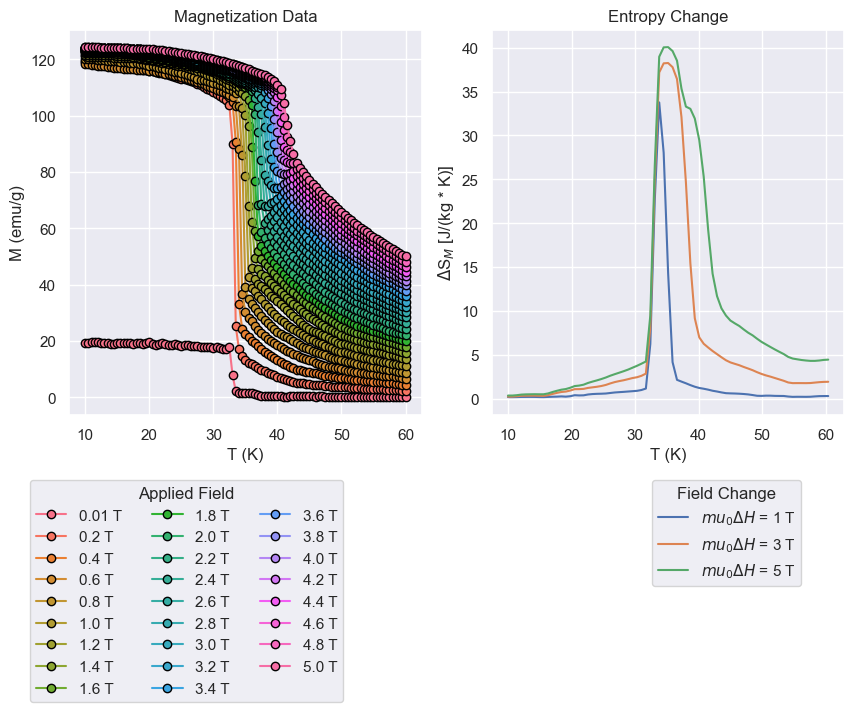

In [151]:
SAVED_WEIGHTS = "optest/modeltrial_14/"
model = tf.keras.models.load_model(SAVED_WEIGHTS)
sim_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
new_model_entropy = plot_entropy_curve(data=sim_data, 
                                       temperature_column="t", 
                                       field_column="h", 
                                       magnetization_column="m", 
                                       unstandarize=True,  
                                       bbox_mag = (0.8, -0.15), 
                                       n_cols=3, 
                                       bbox_ds = (0.9, -0.15), 
                                       return_entropy = True)

## Finally comparing with all the other models:


Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

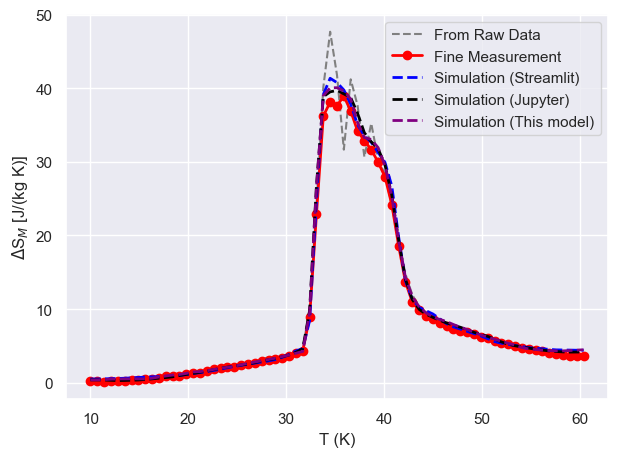

In [152]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    df_plot_3 = entropy_fine.query("dh == @field")
    df_plot_4 = jupyter_sim.query("dh == @field")
    df_plot_5 = new_model_entropy.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'--', mec='black', label = "From Raw Data", color='grey')
    plt.plot(df_plot_3.t, df_plot_3.ds,'o-', label = "Fine Measurement", color='red', lw=2)
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation (Streamlit)", color='blue', lw=2)
    plt.plot(df_plot_4.t, df_plot_4.ds,'--', label = "Simulation (Jupyter)", color='black', lw=2)
    plt.plot(df_plot_5.t, df_plot_5.ds,'--', label = "Simulation (This model)", color='purple', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Comparison with Scikit learn modules

Here we will show the usage of scikit-learn modules such as RandomForest Regression, Linear Regression and MLP Regressor

In [225]:
from mat_interp.model.train_model import load_train_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from mat_interp.model.viz_model import generate_data_mce

# Setup the data (same as before) and the target columsn
EXP_DATA = "../example_data/traindata_Section3_1.csv"
feature_columns = ['X1_demo1', 'X2_demo1']
target_column = ['Y_demo1']
X_train, y_train = load_train_data(EXP_DATA, feature_columns, target_column)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [226]:
scaler = StandardScaler()
pipe_model = lambda pipe_model: Pipeline([['scaler', scaler], ['model', pipe_model]])

In [227]:
linear = pipe_model(LinearRegression())
rf = pipe_model(RandomForestRegressor(n_jobs = - 1))
nn_skl = pipe_model(MLPRegressor(hidden_layer_sizes=(193,) *6, 
             learning_rate_init=0.00434, 
             max_iter = 500, 
             early_stopping=True, 
             ))
guassian_process = pipe_model(GaussianProcessRegressor())
kernel_ridge = pipe_model(KernelRidge(kernel = "rbf"))

In [228]:
models = [("linear", linear), 
          ("random forest", rf), 
          ("nn-scikit", nn_skl), 
          ("gaussian_process", guassian_process), 
          ("kernel", kernel_ridge)]
results = {}

Training linear....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training random forest....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training nn-scikit....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training gaussian_process....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training kernel....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!


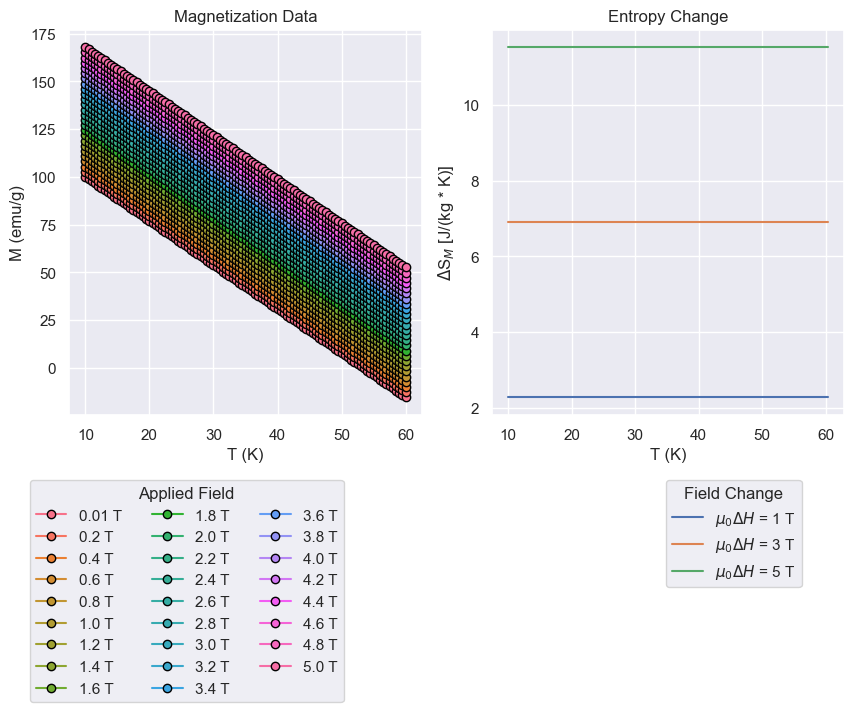

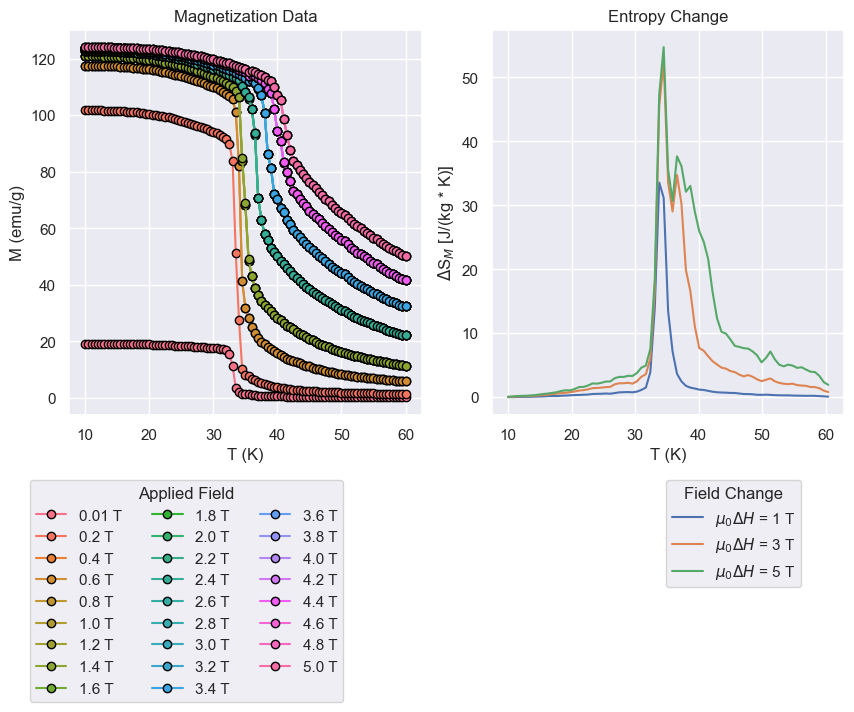

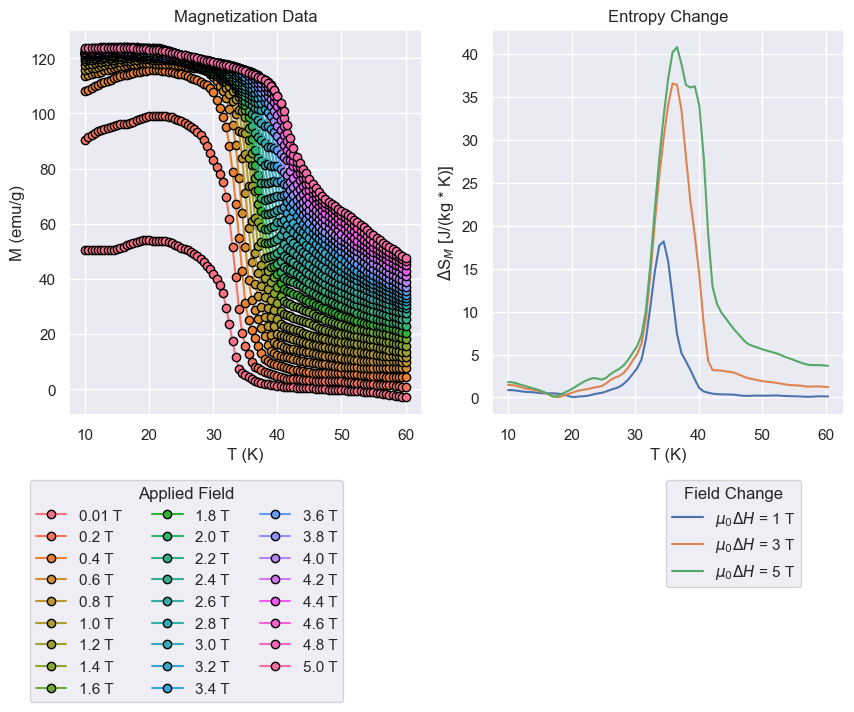

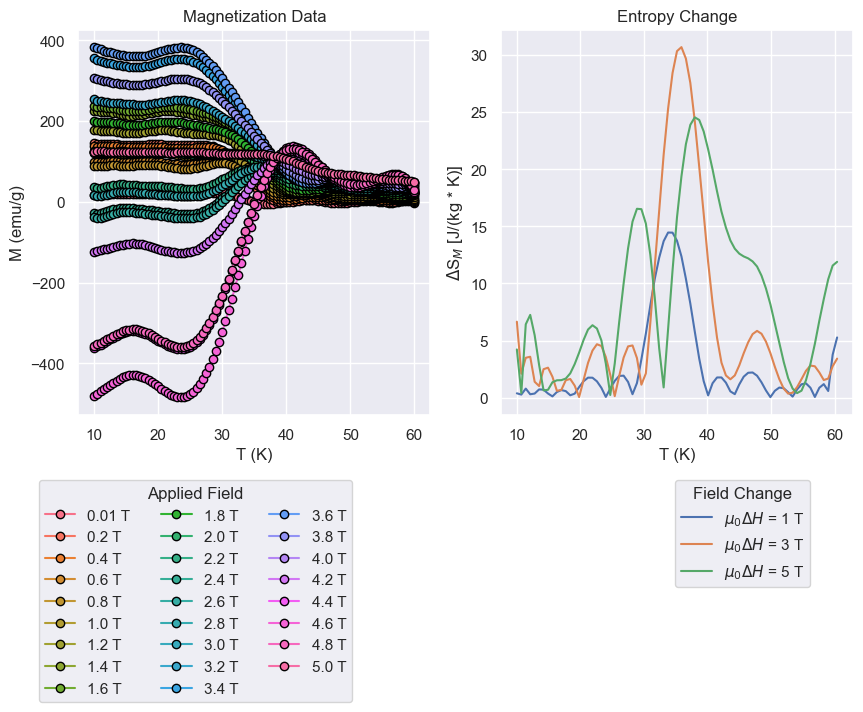

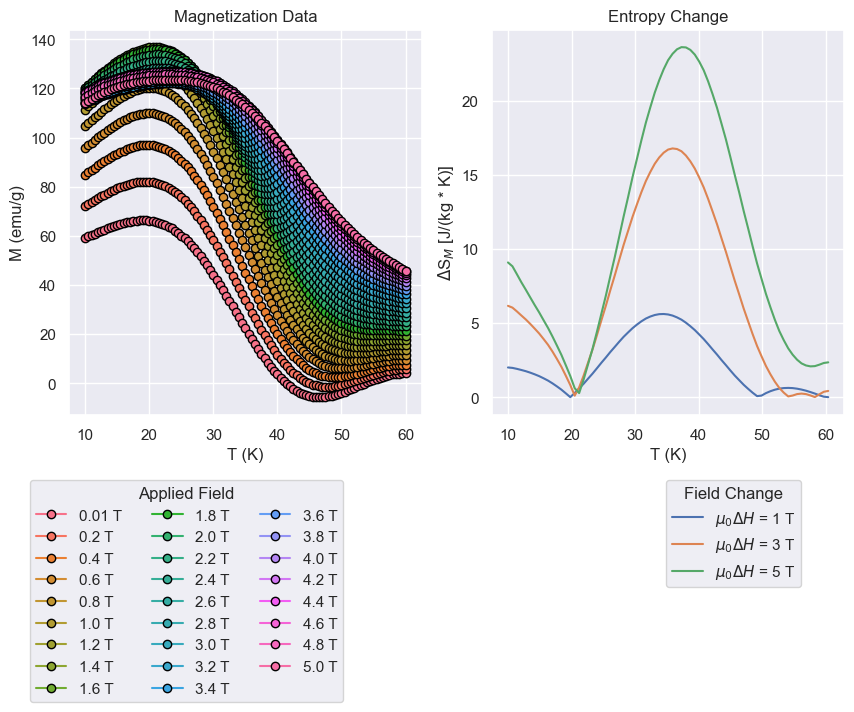

In [232]:
for model_type, model in models:
    print(f"Training {model_type}....")
    model.fit(X_train, y_train)
    gen_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
    entropy = plot_entropy_curve(data=gen_data, 
                       temperature_column="t", 
                       field_column="h", 
                       magnetization_column="m", 
                       unstandarize=False,  
                       bbox_mag = (0.8, -0.15), 
                       n_cols=3, bbox_ds = (0.9, -0.15),
                       return_entropy = True)
    results[model_type] = (entropy, gen_data, model)
    print("Finished!")

# Now check with old results

In [247]:
import seaborn as sns
ds_dataframes = [
    (entropy_exp, 'Exp. (Coarse)'),
    (entropy_fine, 'Exp. (Fine)'),
#     (sim_entropy, 'Simulated (Streamlit)'),
    (jupyter_sim, 'Simulated (Jupyter)'),
#     (new_model_entropy, 'Simulated (New Model)'),
    (results['linear'][0], 'Linear'),
    (results['random forest'][0], 'Random Forest'),
    (results['nn-scikit'][0], 'Neural Net. (sklearn)'),
    (results['gaussian_process'][0], 'Guassian Process'),
    (results['kernel'][0], 'Kernel Regression')
]
colors = ["grey", "red"] + list(sns.color_palette(palette = "dark", n_colors=len(ds_dataframes) - 2))
paramaters = ['--', 'o-', 'v-'] + ['-.']*(len(ds_dataframes) - 3)



(20.0, 50.0)

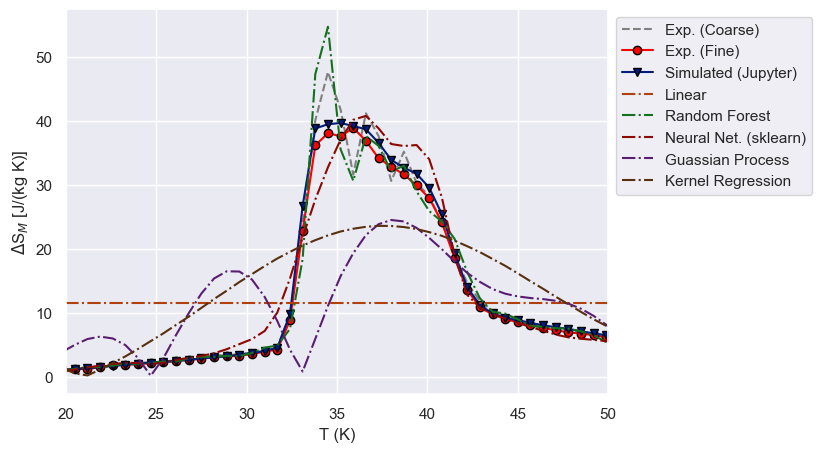

In [248]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for (ds_df, label), color, param in zip(ds_dataframes, colors, paramaters):
    df_plot = ds_df.query("dh == @field")
    plt.plot(df_plot.t, df_plot.ds,param, mec='black', label = label, color=color)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")
plt.xlim([20,50])